### Filter data for commercial/industrial/manufacturing/hybrid zones

In [1]:
# Load raw data

import pandas as pd

LAcity_zoning_df = pd.read_csv("data/raw/LAcity_zoning_raw_2026_01_14.csv")

LAcity_zoning_df.head(5)

,shape_len,shape_area,zone_cmplt,the_geom
0,449.920411,12495.771484,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
1,449.938552,12496.858398,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
2,349.950350,6248.760742,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
3,349.940361,6248.511719,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."
4,449.940411,12497.520508,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1..."


In [2]:
#Inspect zoning data
LAcity_zoning_df['zone_cmplt'].value_counts()

zone_cmplt
R1-1           7914
RS-1           2442
R3-1           2383
R2-1           1713
C2-1VL-CPIO    1385
               ... 
QRD3-1-CUGU       1
QRD2-1-CUGU       1
QRD2-1-RIO        1
(T)(Q)M2-2D       1
(T)(Q)C2-4D       1
Name: count, Length: 1940, dtype: int64

General structure of LA zoning codes:    
[Prefix modifiers][Base Zone][Height District][Suffix overlays]   
where not every code has every component.    
    
E.g. a (T)(Q)C2-4D     
Components
- **a** → *Prefix modifier*  
  Often denotes a specific amending ordinance or administrative designation
- **(T)** → *Transitional zone*  
  Temporary zoning classification
- **(Q)** → *Qualified condition*  
  Site-specific restrictions or conditions
- **C2** → *Base zone*  
  - **C** = Commercial  
  - **2** = Community Commercial
- **4D** → *Height District*  
  Higher intensity commercial allowed

#### Filter by zone - for commercial/industrial zones 

In [3]:
#Define zone category labels according to 'zone_cmplt' values, append this to df for filtering step
import re

def classify_zone(zone):
    if pd.isna(zone):
        return "Unknown"

    # Commercial base zones
    if re.search(r"\bC\d", zone):
        return "Commercial"

    # Manufacturing / industrial base zones
    if re.search(r"\bM\d", zone):
        return "Industrial"

    # Hybrid commercial-manufacturing
    if re.search(r"\(CM\)", zone):
        return "Commercial/Industrial"

    return "Other"

In [4]:
LAcity_zoning_df['zone_category'] = LAcity_zoning_df['zone_cmplt'].apply(classify_zone)

In [5]:
LAcity_zoning_df.head(5)

,shape_len,shape_area,zone_cmplt,the_geom,zone_category
0,449.920411,12495.771484,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Other
1,449.938552,12496.858398,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Other
2,349.950350,6248.760742,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Other
3,349.940361,6248.511719,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Other
4,449.940411,12497.520508,(F)CM-1-CUGU,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Other


In [6]:
#Filter by commercial/industrial 

solar_candidate_zones = LAcity_zoning_df[
    LAcity_zoning_df['zone_category'].isin(['Commercial', 'Industrial', 'Commercial/Industrial'])
].copy()


In [7]:
solar_candidate_zones.head(5)

,shape_len,shape_area,zone_cmplt,the_geom,zone_category
17,159.922768,1312.053711,(Q)C1-1-RIO,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Commercial
18,350.015358,6250.597656,(Q)C1-1,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Commercial
20,520.388311,10549.965820,(Q)C1-1,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Commercial
21,1982.576580,166992.069336,C1-1-SN-CPIO,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Commercial
22,1055.103294,54536.604492,(Q)C1-1XL,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",Commercial


In [8]:
type(solar_candidate_zones['the_geom'].iloc[0])

str

In [9]:
solar_candidate_zones['the_geom'].head(3)

17    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
18    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
20    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
Name: the_geom, dtype: object

Because we loaded from csv, 'the_geom' column is a string and we need it to be a dict

In [10]:
# Convert Socrata GeoJSON polygons to Shapely geometry objects
import ast
from shapely.geometry import shape

def parse_geom(x):
    if isinstance(x, dict):
        return shape(x)
    elif isinstance(x, str):
        try:
            return shape(ast.literal_eval(x))
        except Exception:
            return None
    else:
        return None

solar_candidate_zones['geometry'] = solar_candidate_zones['the_geom'].apply(parse_geom)


In [11]:
solar_candidate_zones['the_geom'].head(3)

17    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
18    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
20    {'type': 'MultiPolygon', 'coordinates': [[[[-1...
Name: the_geom, dtype: object

In [12]:
import geopandas as gpd

# Create a gdf. Socrata uses WGS84 (EPSG:4326)
solar_candidate_zones_gdf = gpd.GeoDataFrame(solar_candidate_zones, geometry='geometry', crs='EPSG:4326')


#### Save gdf in EPSG:4326

In [ ]:
#Save
solar_candidate_zones_gdf.to_file(
    "data/commercial_industrial/LA_commercial_industrial_zoning_4326.gpkg",
    driver="GPKG"
)

In [19]:
# Create bbox polygon
from shapely.geometry import box
minx, miny, maxx, maxy = solar_candidate_zones_gdf.total_bounds
bbox_geom = box(minx, miny, maxx, maxy)


# Wrap in a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(
    geometry=[bbox_geom],
    crs="EPSG:4326"
)

In [20]:
# Convert CRS to Web mercator for basemap plotting
solar_candidate_zones_gdf_web = solar_candidate_zones_gdf.to_crs(epsg=3857)

#### Save gdf in ESPG 3857 Web Mercator

In [21]:
#Save in web mercator CRS

#Export gdf- can be used in QGIS/ArcGIS
solar_candidate_zones_gdf_web.to_file(
    "data/commercial_industrial/LA_commercial_industrial_zoning_3857.geojson",
    driver="GeoJSON"
)

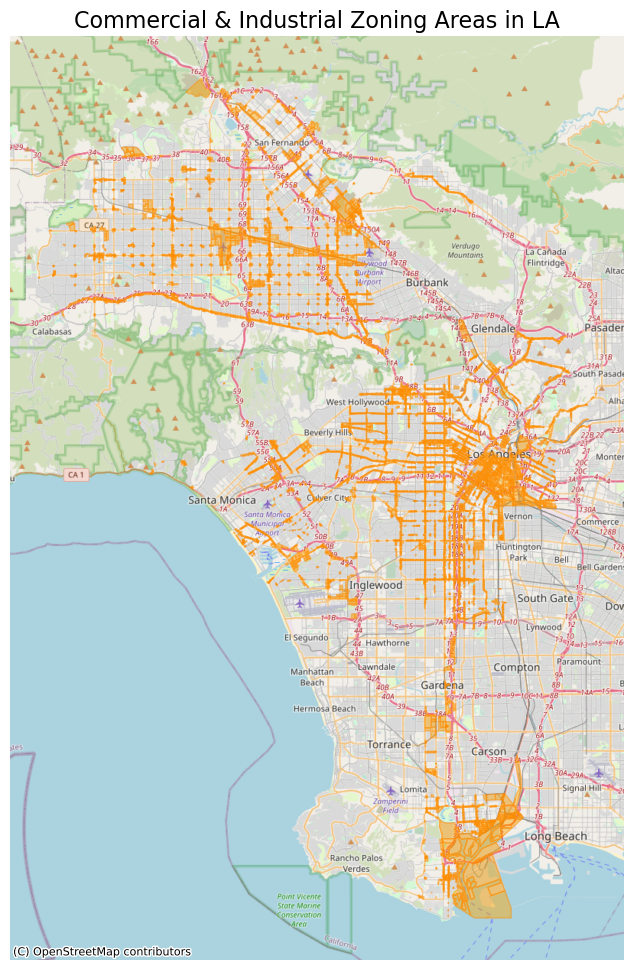

In [22]:
import matplotlib.pyplot as plt

#from shapely.geometry import shape

# Plot over a basemap 
import contextily as ctx

fig, ax = plt.subplots(figsize=(12,12))

# Plot polygons with semi-transparent fill
solar_candidate_zones_gdf_web.plot(ax=ax, alpha=0.45, edgecolor='#FF8C00', color='orange')

# Add basemap (light, street-level context)
#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("Commercial & Industrial Zoning Areas in LA", fontsize=16)
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
#plt.savefig("LA_commercial_zoning.png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()

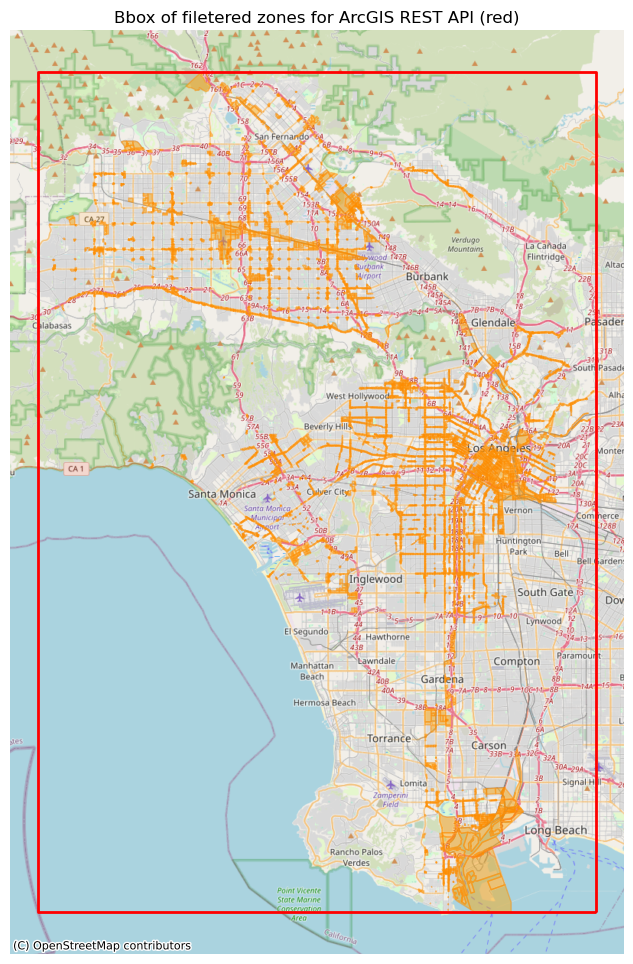

In [25]:
#import matplotlib.pyplot as plt

# Reproject bbox to Web Mercator for basemap
bbox_web = bbox_gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 12))

# Plot filtered zone polygons with semi-transparent fill
solar_candidate_zones_gdf_web.plot(ax=ax, alpha=0.45, edgecolor='#FF8C00', color='orange')

# Plot bbox 
bbox_web.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2
)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("Bbox of filetered zones for ArcGIS REST API (red)")
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
#plt.savefig(".png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()
